In [5]:
from HodaDatasetReader import read_hoda_cdb, read_hoda_dataset

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

import logging
tf.get_logger().setLevel(logging.ERROR)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import cv2
import pickle
import random 
import time
import zipfile
from shutil import copyfile


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout


## Import train dataset

In [33]:
X_train, y_train = read_hoda_dataset(dataset_path='Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=True)

X_val = X_train[45000:]
y_val = y_train[45000:]
X_train = X_train[:35000]# Decrease the nymber of train instances to have low accuracy for comparing with real handwriting
y_train = y_train[:35000]

In [34]:
X_train.shape

(35000, 1024)

In [35]:
X_val.shape

(15000, 1024)

## Import Test dataset

In [ ]:
X_test, y_test = read_hoda_dataset(dataset_path='Test 20000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=True)

In [ ]:
X_test.shape

(20000, 1024)

## reshape X_train , X_val,X_test

In [38]:
X_train = X_train.reshape(X_train.shape[0], 32, 32)
X_test = X_test.reshape(X_test.shape[0], 32,32)
X_val=X_val.reshape(X_val.shape[0], 32,32)

In [39]:
X_train.shape

(35000, 32, 32)

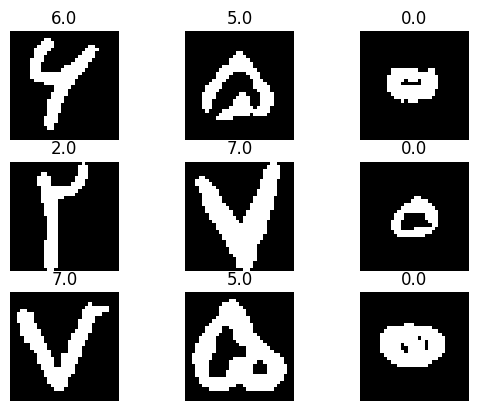

In [40]:
for i in range(9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i].squeeze(),cmap='gray' )
    plt.axis('off')
    plt.title(y_train[i])

In [41]:
y_train.dtype

dtype('float32')

In [42]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)


In [43]:
X_train.shape

(35000, 32, 32, 1)

## Normalization

In [44]:
X_train, X_val, X_test = X_train / 255, X_val / 255, X_test/ 255

In [45]:
y_train.shape

(35000,)

In [46]:
y_train = y_train.astype('uint8')
y_test = y_test.astype('uint8')
y_val = y_val.astype('uint8')

In [47]:
y_train.shape

(35000,)

## Identify the class of digits

In [48]:
class_names = [0.0, 1.0, 2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0]
class_names[y_train[0]]

6.0

In [49]:
y_test.shape

(20000,)

# 1.Sequentional

In [50]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[32, 32]),
tf.keras.layers.Dense(300, activation="relu"),
tf.keras.layers.Dense(100, activation="relu"),
tf.keras.layers.Dense(10, activation="softmax")
])

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 300)               307500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 338,610
Trainable params: 338,610
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.layers

In [53]:
model.compile(loss="sparse_categorical_crossentropy",
optimizer="Adam",
metrics=["accuracy"])

In [54]:
history = model.fit(X_train, y_train, epochs=10,
validation_data=(X_val, y_val))

Epoch 1/10


2023-03-09 17:12:35.711404: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 143360000 exceeds 10% of free system memory.


1094/1094 [==============================] - 10s 8ms/step - loss: 0.4901 - accuracy: 0.8726 - val_loss: 0.2057 - val_accuracy: 0.9437
Epoch 2/10
1094/1094 [==============================] - 9s 8ms/step - loss: 0.1742 - accuracy: 0.9497 - val_loss: 0.1746 - val_accuracy: 0.9491
Epoch 3/10
1094/1094 [==============================] - 9s 8ms/step - loss: 0.1408 - accuracy: 0.9608 - val_loss: 0.1499 - val_accuracy: 0.9588
Epoch 4/10
1094/1094 [==============================] - 9s 8ms/step - loss: 0.1179 - accuracy: 0.9669 - val_loss: 0.1273 - val_accuracy: 0.9643
Epoch 5/10
1094/1094 [==============================] - 9s 8ms/step - loss: 0.1008 - accuracy: 0.9723 - val_loss: 0.1113 - val_accuracy: 0.9689
Epoch 6/10
1094/1094 [==============================] - 9s 8ms/step - loss: 0.0860 - accuracy: 0.9758 - val_loss: 0.1038 - val_accuracy: 0.9707
Epoch 7/10
1094/1094 [==============================] - 9s 8ms/step - loss: 0.0734 - accuracy: 0.9795 - val_loss: 0.0929 - val_accuracy: 0.9745
Ep

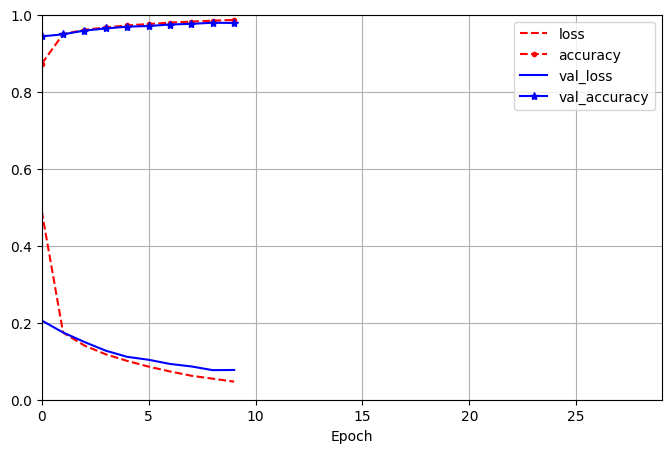

In [ ]:
pd.DataFrame(history.history).plot(
figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True,
xlabel="Epoch",
style=["r--", "r--.", "b-", "b-*"])
plt.show()

# Saving model

In [60]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [61]:
# Save the model
filepath = 'Sequentional'
save_model(model, filepath)

2023-03-09 17:14:28.412156: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Load model

In [62]:
filepath = 'Sequentional'

model_S = load_model(filepath, compile = True)

## Predict my handswriting

In [63]:
img_path = "My/"

In [64]:
lable=['0','1','2','3','4','5','6','7','8','9']


In [65]:
img_list = []
label_list = []
for label in lable:
    for img_file in os.listdir(img_path+label):
        img_list.append(img_path+label+'/'+img_file)
        label_list.append(label)
        
df = pd.DataFrame({'img':img_list, 'label':label_list})
df

,img,label
0,My/0/0.jpg,0
1,My/1/1.jpg,1
2,My/2/2.jpg,2
3,My/3/3.jpg,3
4,My/4/4.jpg,4
5,My/5/5.jpg,5
6,My/6/6.jpg,6
7,My/7/7.jpg,7
8,My/8/8.jpg,8
9,My/9/9.jpg,9


In [66]:
df['label']=df.label.astype('uint8')


In [67]:
df['img'].shape

(10,)

In [68]:
class_names = [0.0, 1.0, 2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0]
class_names[df['label'][6]]

6.0

In [69]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

In [71]:
X = []
for img in df['img']:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (32, 32))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = 255 - gray # change the range of real handwriting for matching with dataset instance
    gray = gray/255
    X.append(gray)

In [72]:
X=np.asarray(X)

In [73]:
X.shape

(10, 32, 32)

In [74]:
X= X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [75]:
X.shape

(10, 32, 32, 1)

In [76]:
y=df['label']

In [77]:
y=np.asarray(y)

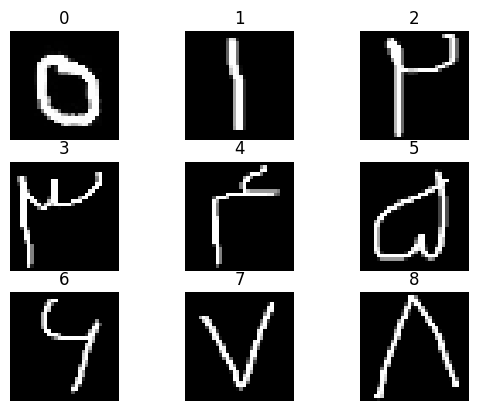

In [78]:
for i in range(9):
    plt.subplot(330 + (i+1))
    plt.imshow(X[i].squeeze(),cmap='gray' )
    plt.axis('off')
    plt.title(y[i])

In [79]:
X_n = X
y_proba = model_S.predict(X_n)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [80]:
y_predi = y_proba.argmax(axis=1)

In [81]:
y_predi = y_proba.argmax(axis=-1)

In [82]:
y_predi

array([5, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### The model can not to predict 0 correctly

In [83]:
from sklearn.metrics import classification_report
print(classification_report(y, y_predi))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1

    accuracy                           0.90        10
   macro avg       0.85      0.90      0.87        10
weighted avg       0.85      0.90      0.87        10

